In [1]:
%history

%history


In [2]:
import torch
import torch.nn as nn   


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)
# Create DataLoader for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Images shape: torch.Size([64, 3, 256, 256])
Labels shape: torch.Size([64])
frog


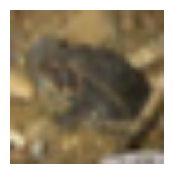

In [9]:
#CIFAR labels to human readable labels
CIFAR10_CLASSES = [
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]
data = next(iter(train_loader))
images, labels = data

# Check the shape of the images and labels
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

#decode the first image
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(2, 2))  # keep this small to avoid blur
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')  # no interpolation
    plt.axis('off')
    plt.show()
print(CIFAR10_CLASSES[labels[0].item()])
imshow(images[0])

In [14]:
from torch.optim.lr_scheduler import CosineAnnealingLR

#create patch of image

def splitBatch(images):
    B,C,H,W = images.shape
    patch_size = 16

    y = []

    for i in range(H//(patch_size)):
        for j in range(W//patch_size):
            x = images[:,:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size]
            x = x.reshape(B,-1)
            y.append(x)

    y = torch.stack(y,dim=1)

    return y

import  torch.nn.functional as F
class MultiHeadAttn(nn.Module):
    def __init__(self,num_head=4,embedding_dim=588):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_head = num_head
        self.head_dim = embedding_dim//num_head
    
        self.linear = nn.Linear(embedding_dim,3*embedding_dim)
        self.out_proj = nn.Linear(embedding_dim,embedding_dim)
        


    
    def forward(self,x):
        #x-> B,Context_length,embedding_dim
        B,C,T = x.shape
        kqv = self.linear(x) #B,Context length,3*embedding dim
        kqv = kqv.reshape(B,C,3,self.num_head,self.head_dim)
        kqv = kqv.permute(2,3,0,1,4)
        k,q,v = kqv[0],kqv[1],kqv[2] #head,B,C,T/head
        attn = (q@(k.transpose(3,2)))/(self.head_dim)**0.5 #head,B,C,C
        attn = F.softmax(attn,dim=-1) # head,B,C,C
        y = attn @ v # head,B,C,T/head
        y = y.permute(1,2,0,3) #B,C,C,T/Head
        y = y.reshape(B,C,-1)
        return self.out_proj(y)

class MLP(nn.Module):
    def __init__(self,embedding_dim):
        super().__init__()
        self.linear1 = nn.Linear(embedding_dim,4*embedding_dim)
        self.relu = nn.GELU()
        self.linear2 = nn.Linear(4*embedding_dim,embedding_dim)
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x



class Transformer(nn.Module):
    def __init__(self,num_head=4,embedding_dim=588):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embedding_dim)
        self.mha = MultiHeadAttn(num_head,embedding_dim)
        self.layer_norm_2 = nn.LayerNorm(embedding_dim)
        self.mlp = MLP(embedding_dim)
    

    def forward(self,x):
        residual = x.clone()
        x = self.layer_norm_1(x)
        x = self.mha(x)
        x = x+residual
        residual = x.clone()
        x = self.layer_norm_2(x)
        x = self.mlp(x)
        x = x + residual
        return x

class VIT(nn.Module):
    def __init__(self,layer_num = 12,patch_size=14,channels = 3,context_length=196,embedding_dim = 588,num_attn_head = 8,class_size=10):
        super(VIT,self).__init__()
        self.context_length = context_length
        self.LinearProj = nn.Linear(in_features=patch_size*patch_size*channels,out_features=588)
        self.embedding = nn.Embedding(num_embeddings=1,embedding_dim=588)
        self.pos_embedding = nn.Embedding(num_embeddings=context_length+1,embedding_dim=588)
        self.encoder_blocks = nn.ModuleList([Transformer(num_head = num_attn_head,embedding_dim=embedding_dim) for i in range(layer_num)])
        self.mlp = MLP(embedding_dim)
        self.class_proj = nn.Linear(embedding_dim,10)


        
    

    def forward(self,image):
        #image---> (B,context_length,P*P*3)
        B,C,feature_size = image.shape
        x = self.LinearProj(image)
        cls_token = self.embedding(torch.tensor([0],device='cuda'))
        cls_token = cls_token.unsqueeze(0).expand(B, 1, -1)  # [64, 1, 768]
        x = torch.cat([cls_token,x],dim=1) 
        pos = torch.arange(0,self.context_length+1).to(device='cuda')
        pos_ = self.pos_embedding(pos)
        x = x + self.pos_embedding(pos)  
        for enc in self.encoder_blocks:
            x = enc(x)
        
        x = self.mlp(x)

        cls_em = self.class_proj(x[:,0])

        return cls_em

vit  = VIT(layer_num=8,patch_size=16,channels=3,context_length=196,embedding_dim=768,num_attn_head=8,class_size=10).to('cuda')
optimizer = torch.optim.Adam(params=vit.parameters(),lr = 1e-3)

print(len(train_loader))
print(len(train_dataset))
num_epoch = 3
num_grad_accum=16
total_loss = 0

scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * num_epoch)  # full schedule over all steps

for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(iter(train_loader)):
        patches = splitBatch(images).to('cuda')
        print('patches',patches.shape)
        y = vit(patches)
        labels = labels.to('cuda')
        loss = F.cross_entropy(y,labels)/num_grad_accum
        total_loss+=loss.item()
        loss.backward()
        if(i%num_grad_accum==1):
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()  # step after every optimizer update

            
        if(i%num_grad_accum==1):
            print(epoch,i,"/",len(train_loader)," : ",total_loss)
            total_loss=0 


782
50000


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

patches torch.Size([64, 256, 768])


RuntimeError: The size of tensor a (257) must match the size of tensor b (197) at non-singleton dimension 1